In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import pandas as pd
import lasagne
from parmesan.distributions import log_bernoulli, kl_normal2_stdnormal
from parmesan.layers import SimpleSampleLayer
from keras.datasets import mnist
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)
Using Theano backend.


In [2]:
#settings
do_train_model = False
batch_size = 100
latent_size = 20
nhidden = 512
lr = 0.001
num_epochs = 50
model_filename = "mnist_ae"
nonlin = lasagne.nonlinearities.rectify

np.random.seed(1234) # reproducibility

In [3]:
#SYMBOLIC VARS
sym_x = T.matrix()
sym_lr = T.scalar('lr')

### LOAD DATA
print "Using MNIST dataset"

(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = (train_x.reshape((-1, 784))/255.0).astype(np.float32)
test_x = (test_x.reshape((-1, 784))/255.0).astype(np.float32)

train_x[train_x > 0.5] = 1.0
train_x[train_x <= 0.5] = 0.0

train_x[train_x > 0.5] = 1.0
train_x[train_x <= 0.5] = 0.0

#setup shared variables
sh_x_train = theano.shared(train_x, borrow=True)
sh_x_test = theano.shared(test_x, borrow=True)

nfeatures=train_x.shape[1]
n_train_batches = train_x.shape[0] / batch_size
n_test_batches = test_x.shape[0] / batch_size

Using MNIST dataset


In [4]:
### RECOGNITION MODEL q(z|x)
l_in = lasagne.layers.InputLayer((batch_size, nfeatures))
l_noise = lasagne.layers.BiasLayer(l_in, b = np.zeros(nfeatures, dtype = np.float32), name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
l_enc_h1 = lasagne.layers.DenseLayer(l_noise, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE1')
l_enc_h1 = lasagne.layers.DenseLayer(l_enc_h1, num_units=nhidden, nonlinearity=nonlin, name='ENC_DENSE2')

l_z = lasagne.layers.DenseLayer(l_enc_h1, num_units=latent_size, nonlinearity=lasagne.nonlinearities.identity, name='Z')

In [5]:
### GENERATIVE MODEL p(x|z)
l_dec_h1 = lasagne.layers.DenseLayer(l_z, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE2')
l_dec_h1 = lasagne.layers.DenseLayer(l_dec_h1, num_units=nhidden, nonlinearity=nonlin, name='DEC_DENSE1')
l_dec_x = lasagne.layers.DenseLayer(l_dec_h1, num_units=nfeatures, nonlinearity=lasagne.nonlinearities.sigmoid, name='DEC_X_MU')

dec_x = lasagne.layers.get_output(l_dec_x, sym_x, deterministic=False)

In [6]:
loss = lasagne.objectives.squared_error(dec_x, sym_x.reshape((batch_size, -1)))
loss = lasagne.objectives.aggregate(loss, mode="mean")

params = lasagne.layers.get_all_params(l_dec_x, trainable=True)
for p in params:
    print p, p.get_value().shape

### Take gradient of Negative LogLikelihood
grads = T.grad(loss, params)

# Add gradclipping to reduce the effects of exploding gradients.
# This speeds up convergence
clip_grad = 1
max_norm = 5
mgrads = lasagne.updates.total_norm_constraint(grads,max_norm=max_norm)
cgrads = [T.clip(g,-clip_grad, clip_grad) for g in mgrads]

ENC_DENSE1.W (784, 512)
ENC_DENSE1.b (512,)
ENC_DENSE2.W (512, 512)
ENC_DENSE2.b (512,)
Z.W (512, 20)
Z.b (20,)
DEC_DENSE2.W (20, 512)
DEC_DENSE2.b (512,)
DEC_DENSE1.W (512, 512)
DEC_DENSE1.b (512,)
DEC_X_MU.W (512, 784)
DEC_X_MU.b (784,)


In [7]:
#Setup the theano functions
sym_batch_index = T.iscalar('index')
batch_slice = slice(sym_batch_index * batch_size, (sym_batch_index + 1) * batch_size)

updates = lasagne.updates.adam(cgrads, params, learning_rate=sym_lr)

train_model = theano.function([sym_batch_index, sym_lr], loss, updates=updates,
                                  givens={sym_x: sh_x_train[batch_slice]},)

test_model = theano.function([sym_batch_index], loss,
                                  givens={sym_x: sh_x_test[batch_slice]},)

plot_results = theano.function([sym_batch_index], dec_x,
                                  givens={sym_x: sh_x_test[batch_slice]},)

def train_epoch(lr):
    costs = []
    for i in range(n_train_batches):
        cost_batch = train_model(i, lr)
        costs += [cost_batch]
    return np.mean(costs)


def test_epoch():
    costs = []
    for i in range(n_test_batches):
        cost_batch = test_model(i)
        costs += [cost_batch]
    return np.mean(costs)

In [8]:
if do_train_model:
    # Training Loop
    for epoch in range(num_epochs):
        start = time.time()

        #shuffle train data, train model and test model
        np.random.shuffle(train_x)
        sh_x_train.set_value(train_x)
            
        train_cost = train_epoch(lr)
        test_cost = test_epoch()

        t = time.time() - start

        line =  "*Epoch: %i\tTime: %0.2f\tLR: %0.5f\tLL Train: %0.3f\tLL test: %0.3f\t" % ( epoch, t, lr, train_cost, test_cost)
        print line
    
    print "Write model data"
    write_model(l_dec_x, model_filename)
else:
    read_model(l_dec_x, model_filename)

In [9]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")
    
def mnist_input(img):
    return np.tile(img, (batch_size, 1, 1, 1)).reshape(batch_size, 784)

def mnist_dist(img1, img2):
    return np.linalg.norm(img1 - img2)

In [10]:
l_z, reconstruction = lasagne.layers.get_output([l_z, l_dec_x], inputs = sym_x, deterministic=True)
# Adversarial confusion cost function
    
# Mean squared reconstruction difference
# KL divergence between latent variables
adv_z =  T.vector()
adv_confusion = lasagne.objectives.squared_error(adv_z, l_z).sum()

# Adversarial regularization
C = T.scalar()
adv_reg = C*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([sym_x, adv_z, C], [adv_loss, adv_grad])

# Helper to plot reconstructions    
adv_plot = theano.function([sym_x], reconstruction)

# Function to get latent variables of the target
adv_l_z = theano.function([sym_x], l_z)

In [17]:
def adv_test(orig_img = 0, target_img = 1, C = 200.0, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))
    
    # Get latent variables of the target
    adv_target_z = adv_l_z(mnist_input(test_x[target_img]))
    adv_target_z = adv_target_z[0]

    original_reconstruction = adv_plot(mnist_input(test_x[orig_img]))[0]
    target_reconstruction = adv_plot(mnist_input(test_x[target_img]))[0]

    orig_recon_dist = mnist_dist(original_reconstruction, test_x[orig_img])
    target_recon_dist = mnist_dist(target_reconstruction, test_x[target_img])
    orig_target_recon_dist = mnist_dist(original_reconstruction, test_x[target_img])
    target_orig_recon_dist = mnist_dist(target_reconstruction, test_x[orig_img])

    # Plot original reconstruction    
    if plot:
        plt.figure(figsize=(10,10))
        show_mnist(test_x[orig_img], 1, "Original image")
        show_mnist(original_reconstruction, 2, "Original reconstruction")

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))
    
    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g = adv_function(mnist_input(test_x[orig_img]), adv_target_z, C)
        return float(f), g.flatten().astype(np.float64)
        
    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])
    
    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    
    adv_img = adv_plot(mnist_input(test_x[orig_img]))[0]
    
    orig_dist = mnist_dist(adv_img, test_x[orig_img])
    adv_dist = mnist_dist(adv_img, test_x[target_img])
    recon_dist = mnist_dist(adv_img, test_x[orig_img]+x)

    # Plotting results
    if plot:
        show_mnist(x, 3, "Adversarial noise")
        show_mnist(test_x[target_img], 4, "Target image")
        show_mnist((test_x[orig_img].flatten()+x), 5, "Adversarial image")
        show_mnist(adv_img, 6, "Adversarial reconstruction")
    
        plt.show()
            
    orig_target_dist = np.linalg.norm(test_x[orig_img] - test_x[target_img])

    returns = (np.linalg.norm(x),
               orig_dist, 
               adv_dist, 
               orig_recon_dist, 
               target_recon_dist, 
               recon_dist,
               orig_target_dist,
               orig_target_recon_dist,
               target_orig_recon_dist)
    
    return returns

In [21]:
def orig_adv_dist(orig_img = None, target_img = None, plot = False, bestC = None):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
    if target_img is None:
        target_label = test_y[orig_img]
        while target_label == test_y[orig_img]:
            target_img = np.random.randint(0, len(test_x))
            target_label = test_y[target_img]
    
    noise_dist = []
    orig_dist=[]
    adv_dist=[]
    target_recon_dist=[]
    recon_dist=[]
    orig_target_dist=[]
    orig_target_recon_dist=[]
    target_orig_recon_dist=[]
    
    C = np.logspace(-20, 20, 100, base = 2, dtype = np.float32)
    
    for c in C:
        noise, od, ad, ore, tre, recd, otd, otrd, tord = adv_test(orig_img, target_img, C=c, plot = False)
        noise_dist.append(noise)
        orig_dist.append(od)
        adv_dist.append(ad)
        target_recon_dist.append(tre)
        recon_dist.append(recd)
        orig_target_dist.append(otd)
        orig_target_recon_dist.append(otrd)
        target_orig_recon_dist.append(tord)

    noise_dist = np.array(noise_dist)
    orig_dist = np.array(orig_dist)
    adv_dist = np.array(adv_dist)
    target_recon_dist = np.array(target_recon_dist)
    recon_dist = np.array(recon_dist)
    orig_target_dist = np.array(orig_target_dist)
    orig_target_recon_dist = np.array(orig_target_recon_dist)
    target_orig_recon_dist = np.array(target_orig_recon_dist)
    
    if bestC is None:
        bestC = C[np.argmax(adv_dist - orig_dist >= 0)-1]

    print orig_img, target_img, bestC

    best_noise, best_orig_dist, best_adv_dist, orig_reconstruction_dist, target_reconstruction_dist, _, _, _, _ = adv_test(orig_img, target_img, C=bestC, plot = plot)

    if plot:
        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=orig_reconstruction_dist, linewidth = 2, color='DarkOrange', label = "Original reconstruction - Original")
        plt.scatter(orig_dist, adv_dist)
        plt.scatter([best_orig_dist], [best_adv_dist], color = "red")
        plt.ylabel("Adversarial distortion")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
        plt.figure()
        plt.axhline(y=target_reconstruction_dist, linewidth = 2, color = 'cyan', label = "Target reconstruction - Target")
        plt.axvline(x=np.linalg.norm(test_x[orig_img]-test_x[target_img]), linewidth = 2, color='DarkOrange', label = "Original - Target")
        plt.scatter(noise_dist, adv_dist)
        plt.scatter([best_noise], [best_adv_dist], color = "red")
        plt.ylabel("Adversarial reconstruction - Target")
        plt.xlabel("Adversarial - Original")
        plt.legend()
        plt.plot()
        
    df = pd.DataFrame({'orig_img': orig_img,
                       'target_img': target_img,
                       'bestC': bestC,
                       'orig_reconstruction_dist': orig_reconstruction_dist,
                       'target_reconstruction_dist': target_reconstruction_dist,
                       'noise_dist': noise_dist,
                       'orig_dist': orig_dist,
                       'adv_dist': adv_dist,
                       'target_recon_dist': target_recon_dist,
                       'recon_dist': recon_dist,
                       'orig_target_dist': orig_target_dist,
                       'orig_target_recon_dist': orig_target_recon_dist,
                       'target_orig_recon_dist': target_orig_recon_dist,
                       'C': C})
    
    return df

1981 827 3872.88


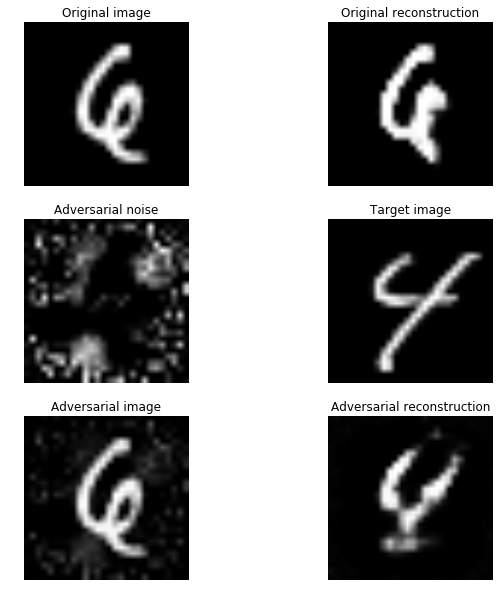

Iter 0 Time 109.083462 sec
6013 5380 1671.67


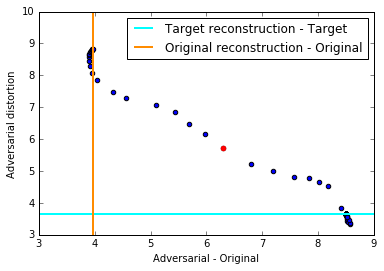

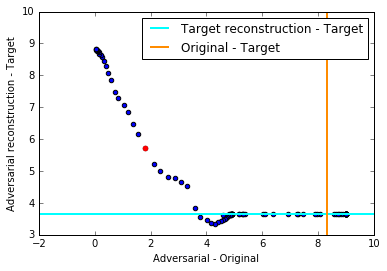

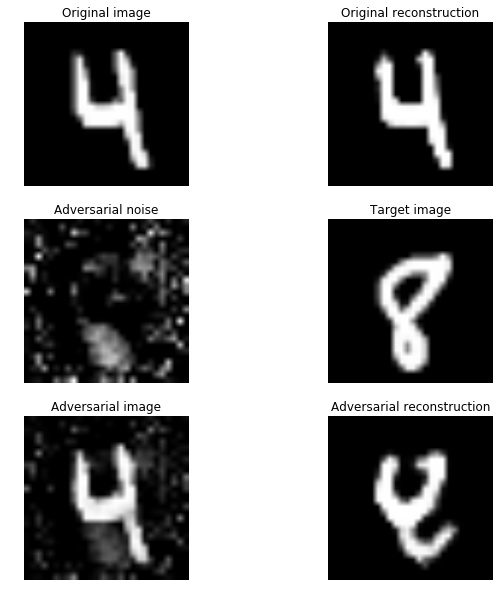

Iter 1 Time 91.1706998348 sec
9278 8006 1263.34


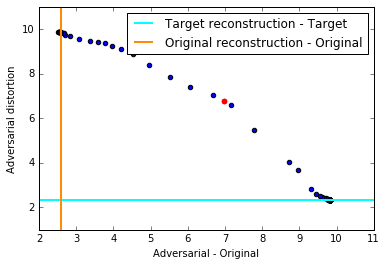

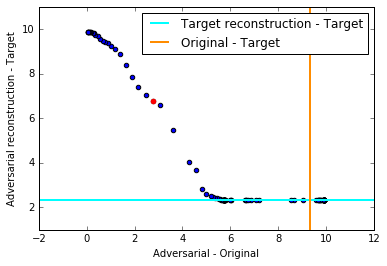

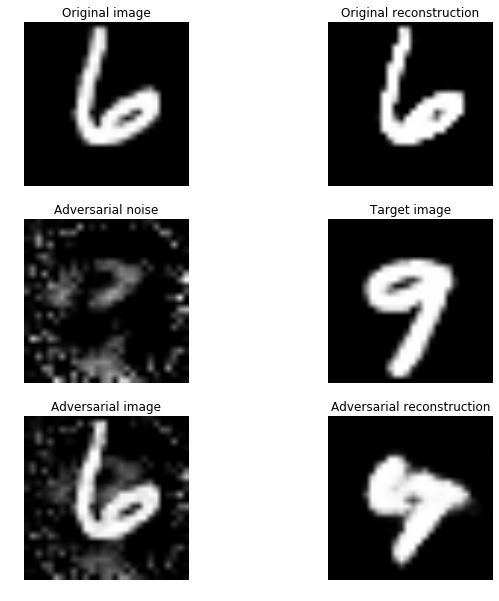

Iter 2 Time 90.8868579865 sec
2050 6832 1263.34


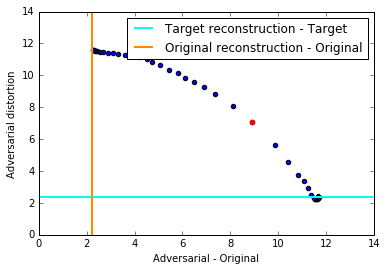

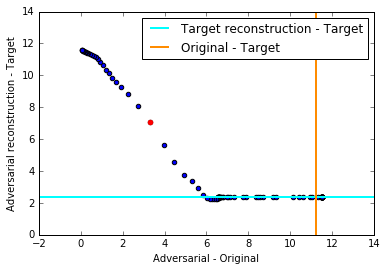

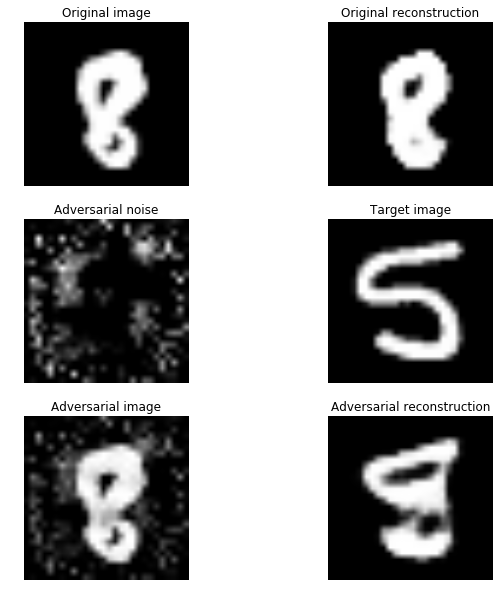

Iter 3 Time 87.6651549339 sec
9564 4224 2926.89


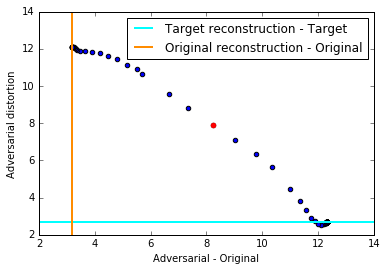

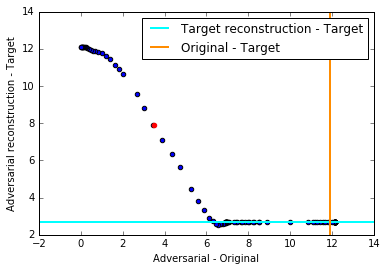

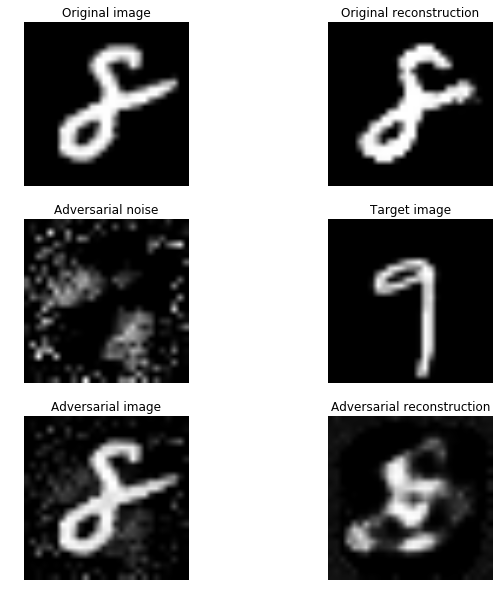

Iter 4 Time 113.139019966 sec
688 2241 954.757


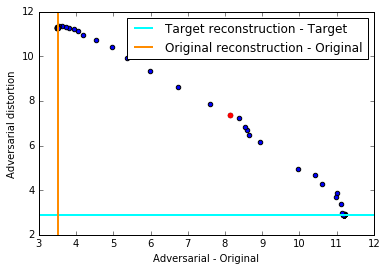

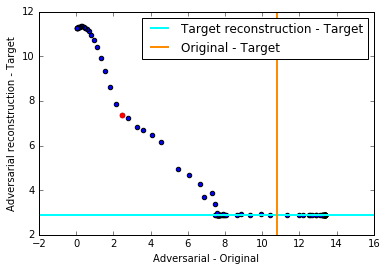

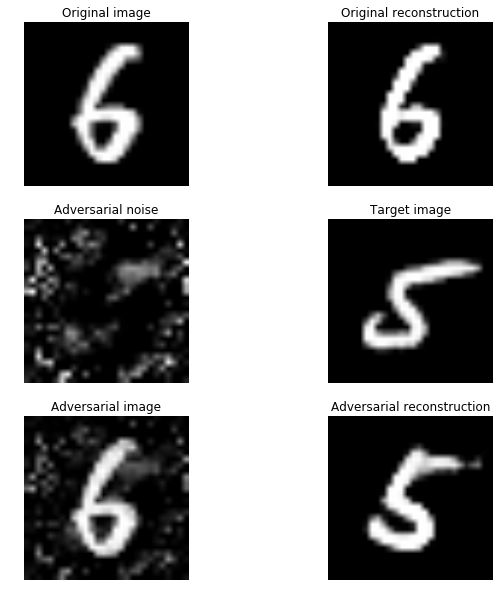

Iter 5 Time 102.324525833 sec
8984 8104 1671.67


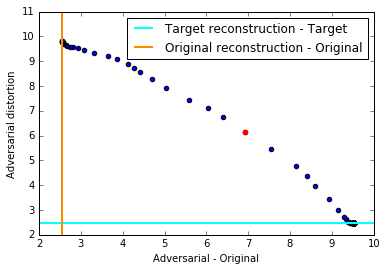

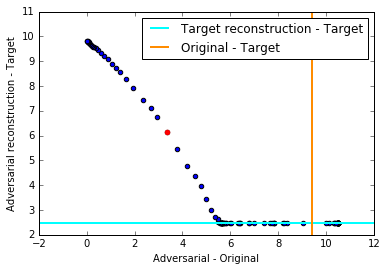

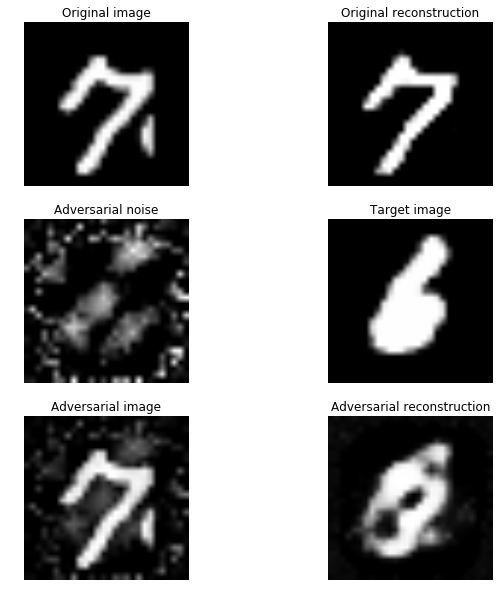

Iter 6 Time 97.1817469597 sec
9416 3177 1671.67


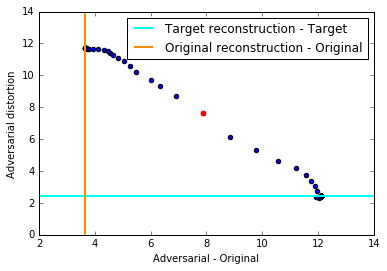

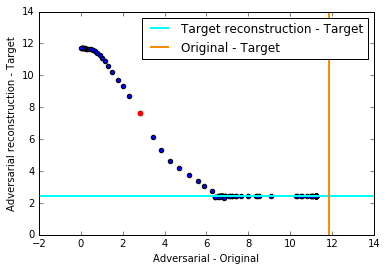

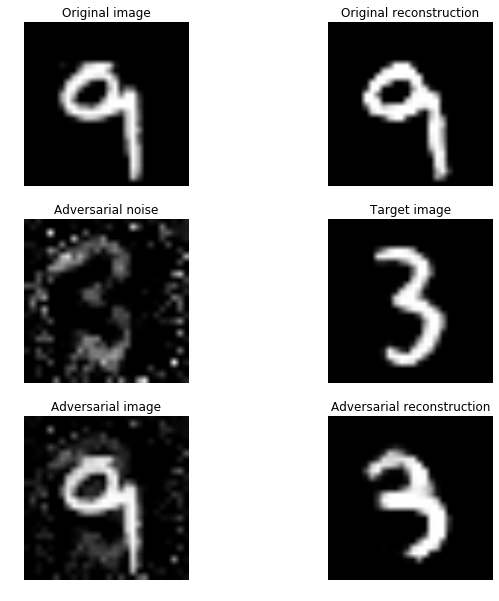

Iter 7 Time 101.238898039 sec
7947 6841 954.757


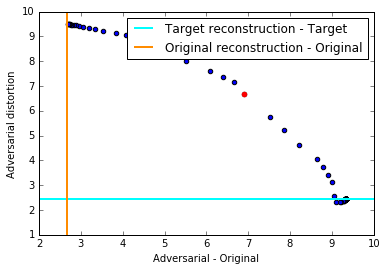

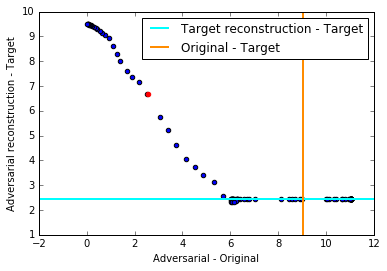

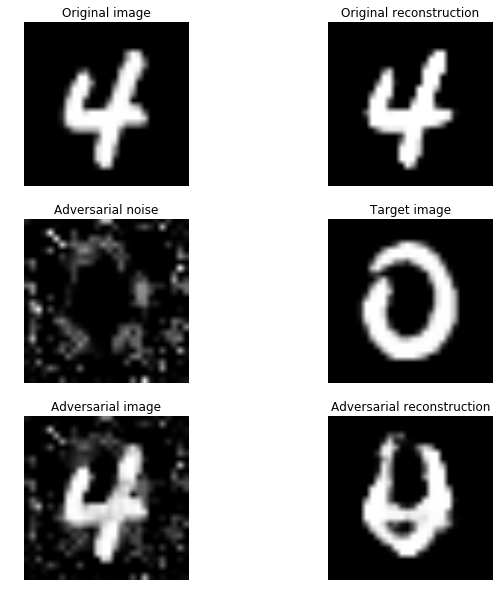

Iter 8 Time 96.355479002 sec
2612 3696 1671.67


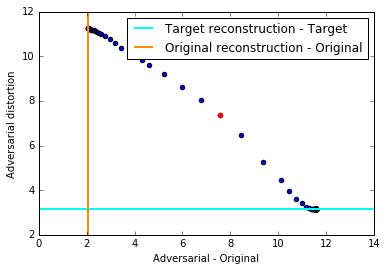

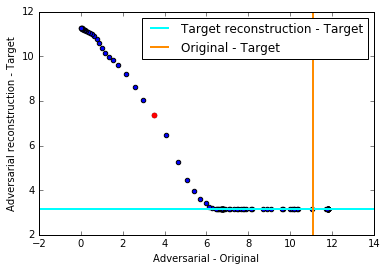

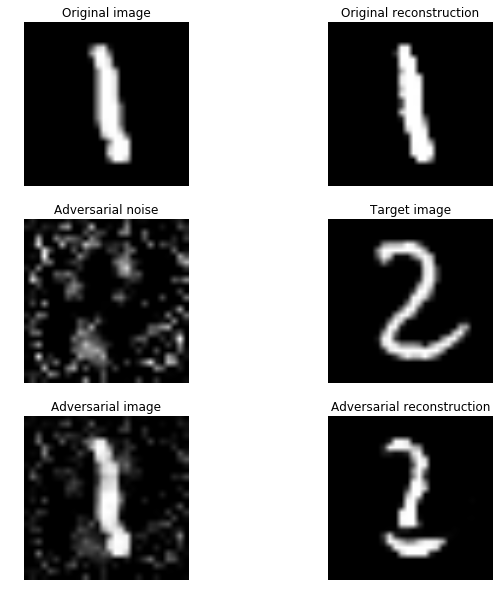

Iter 9 Time 93.8595740795 sec
3469 3149 954.757


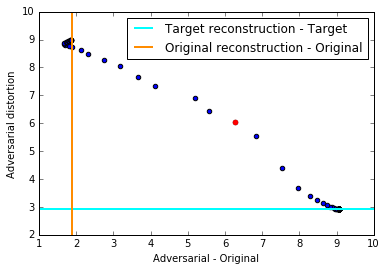

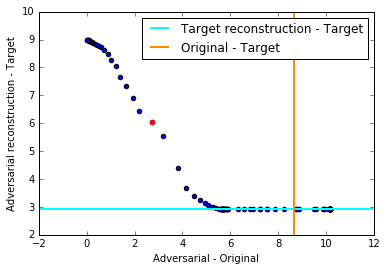

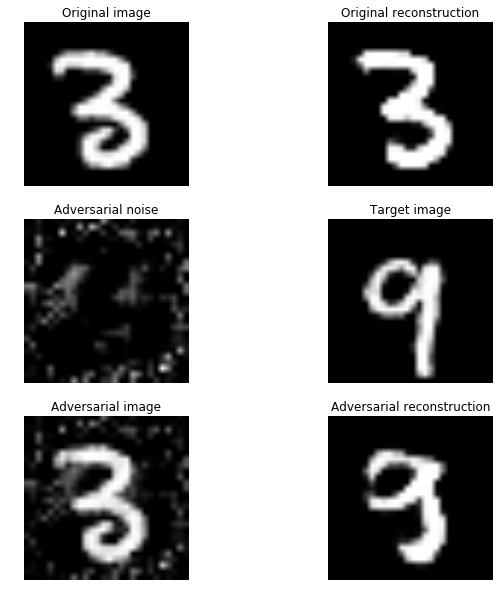

Iter 10 Time 100.352261066 sec
5119 2087 1263.34


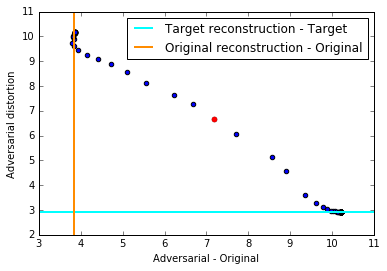

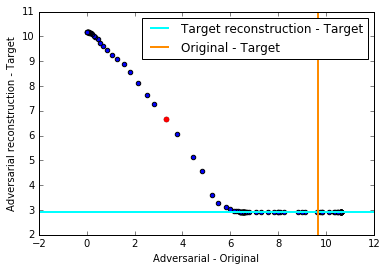

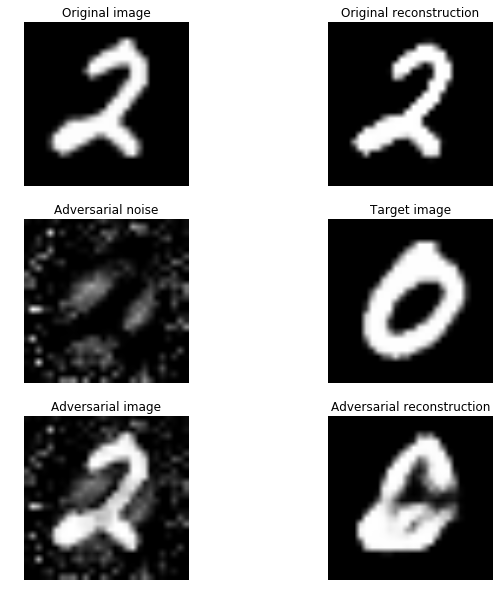

Iter 11 Time 103.711461782 sec
9372 6658 721.547


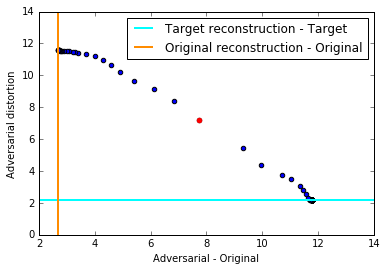

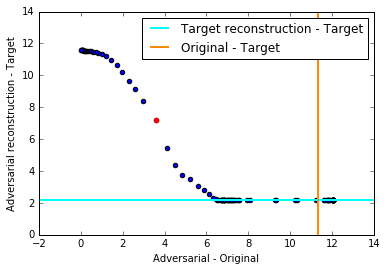

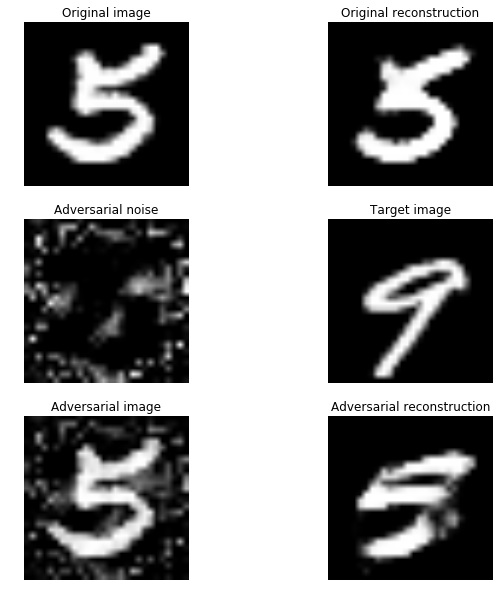

Iter 12 Time 110.30626297 sec
2717 6885 954.757


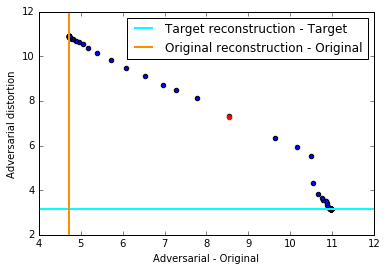

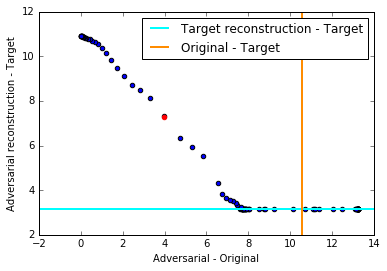

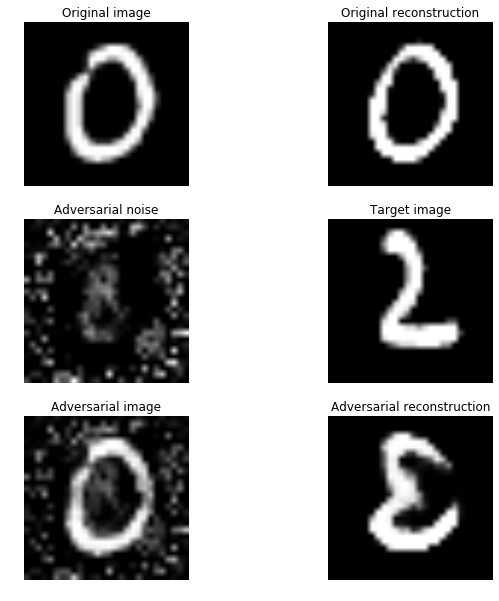

Iter 13 Time 113.859879017 sec
5308 4678 721.547


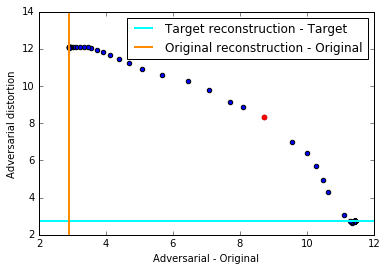

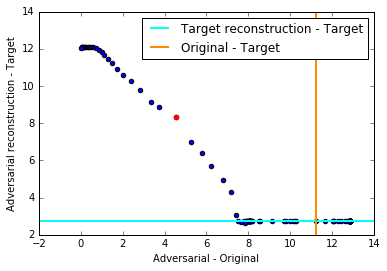

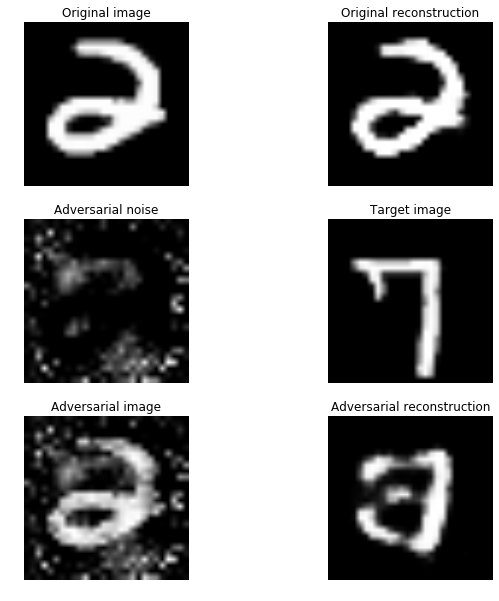

Iter 14 Time 123.286946058 sec
3829 4565 721.547


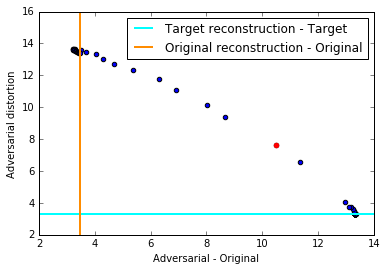

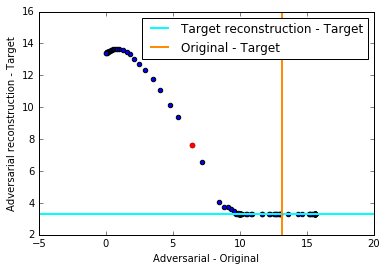

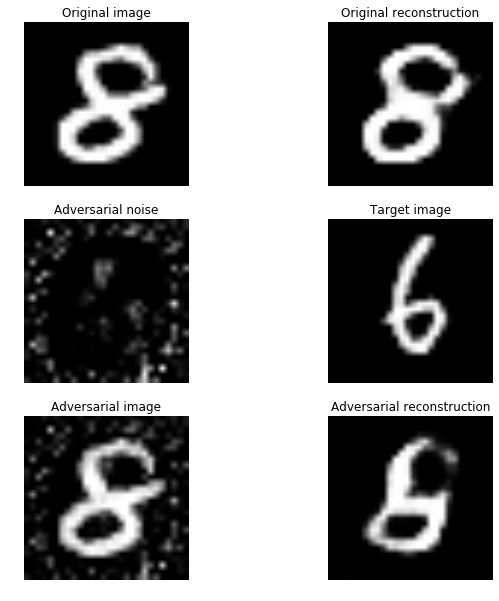

Iter 15 Time 102.832145929 sec
7880 5485 954.757


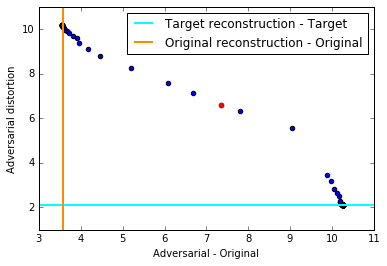

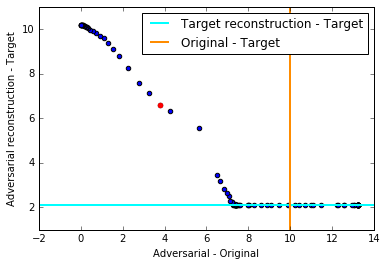

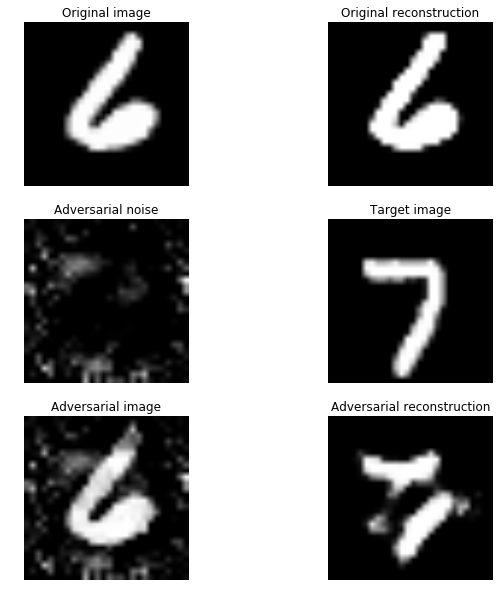

Iter 16 Time 101.765089035 sec
8934 8849 1671.67


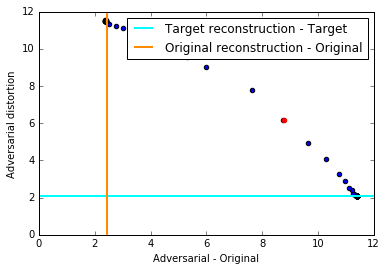

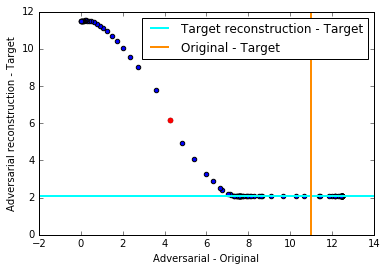

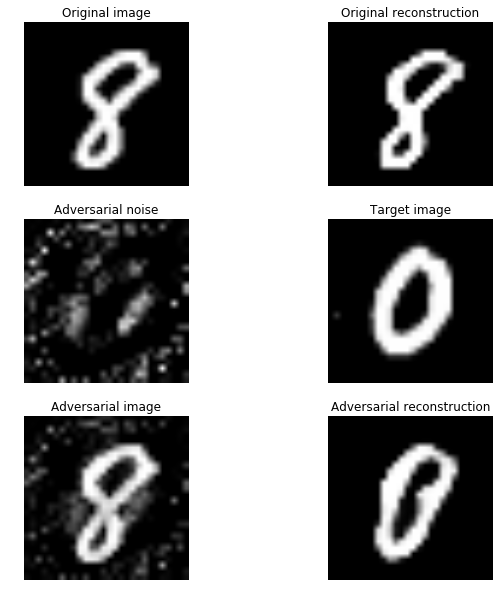

Iter 17 Time 106.357036114 sec
3399 8504 1671.67


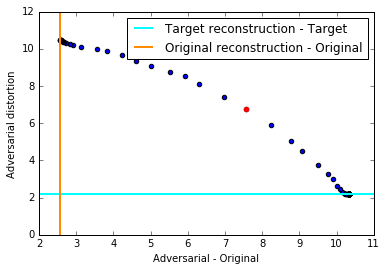

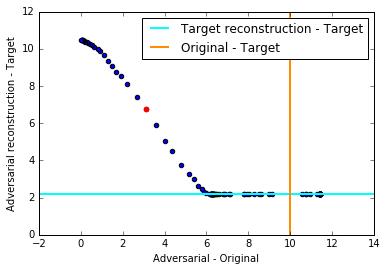

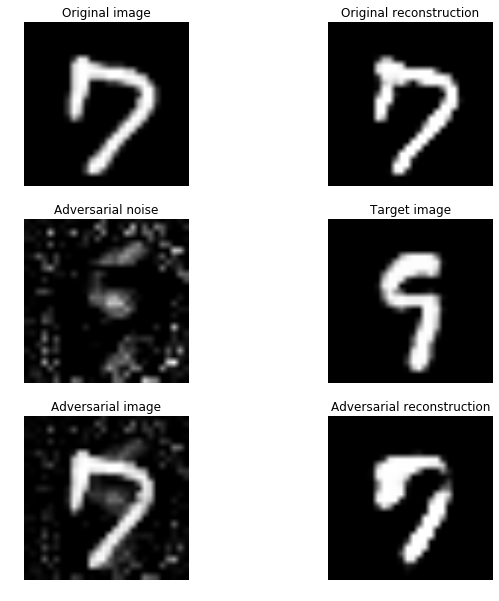

Iter 18 Time 128.998822927 sec
6393 553 2211.96


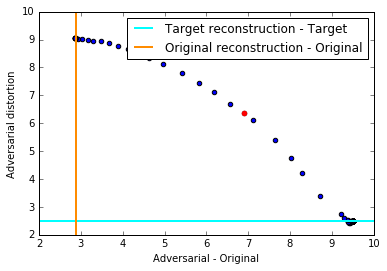

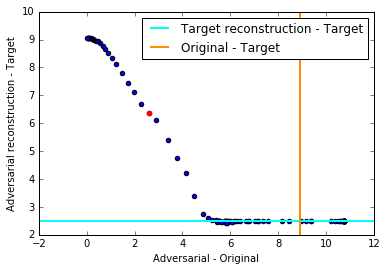

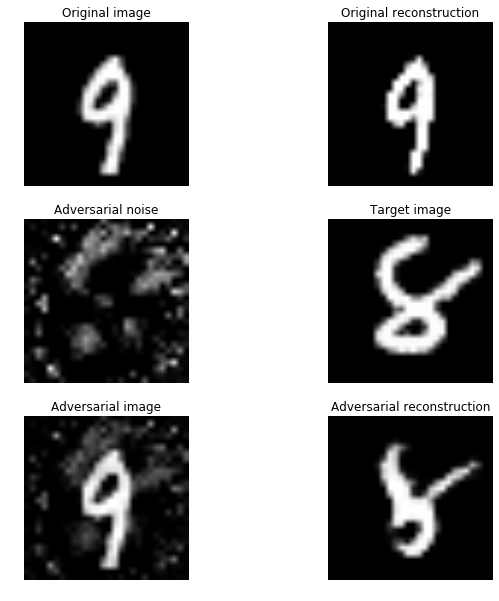

Iter 19 Time 99.4313700199 sec
8120 8993 954.757


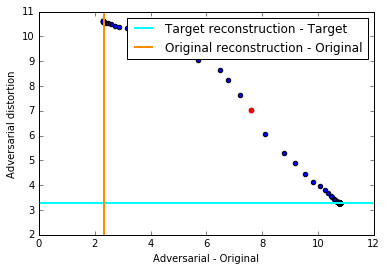

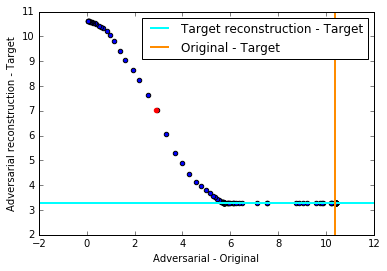

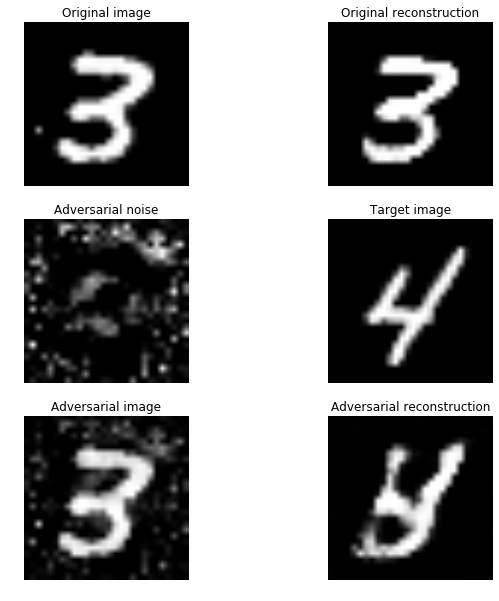

Iter 20 Time 107.246047974 sec
2498 181 1263.34


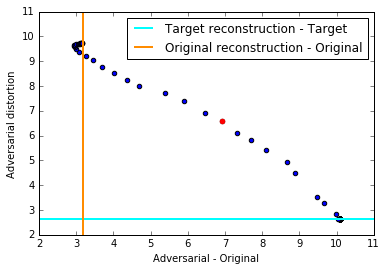

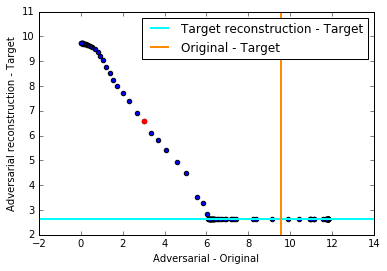

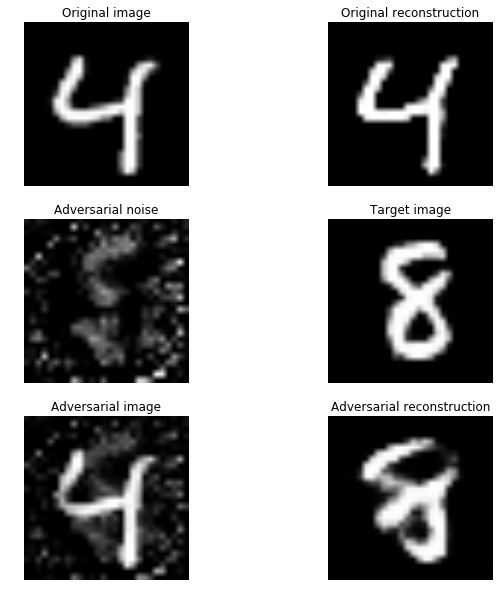

Iter 21 Time 98.7240791321 sec
8317 7313 721.547


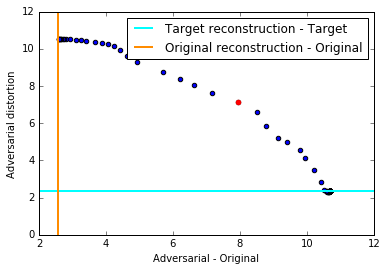

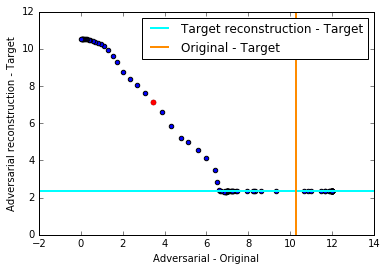

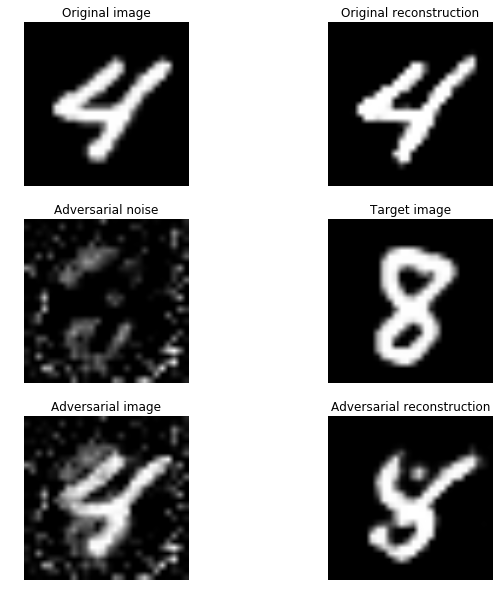

Iter 22 Time 100.761098862 sec
4469 1296 2211.96


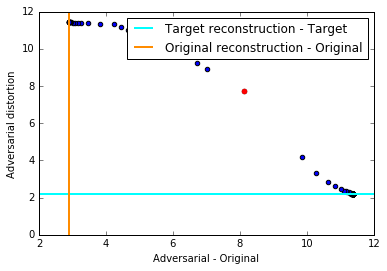

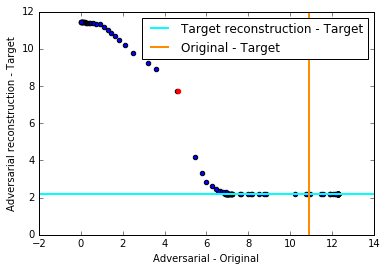

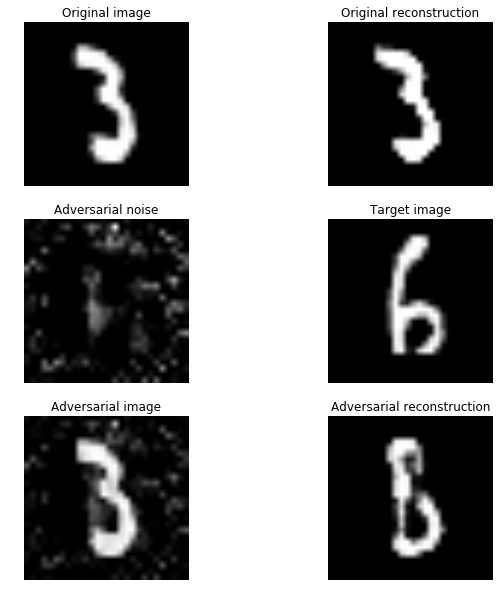

Iter 23 Time 105.363153934 sec
5343 952 1671.67


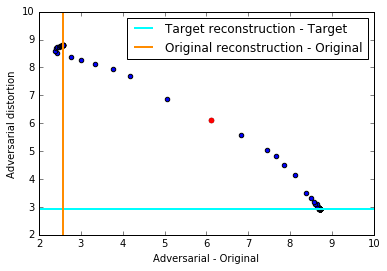

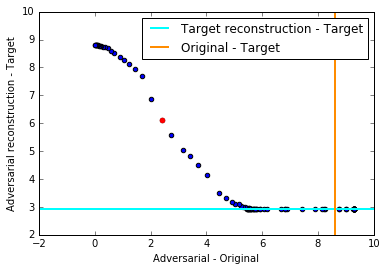

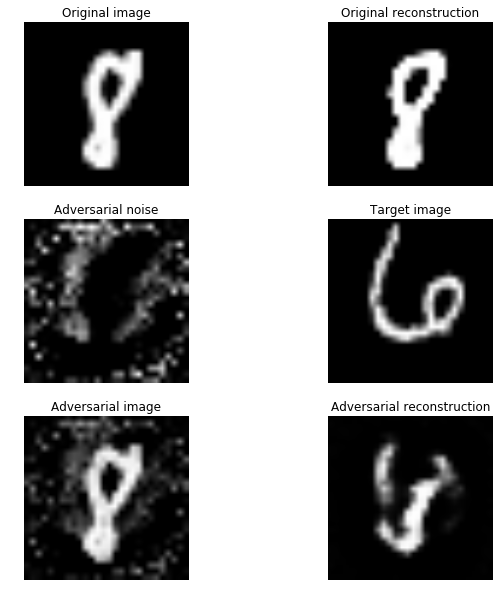

Iter 24 Time 111.874302149 sec


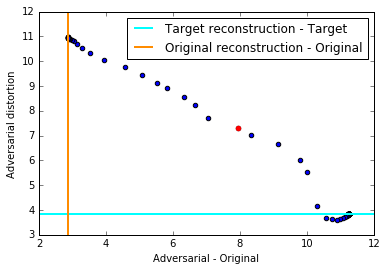

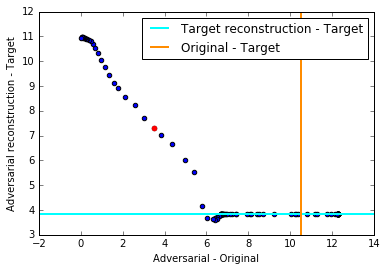

In [22]:
n = 25

for i in range(n):
    start_time = time.time()
    df = orig_adv_dist(plot = True)
    print "Iter", i, "Time", time.time() - start_time, "sec"
    df.to_csv("results/" + model_filename + "/exp_" + str(i) + ".csv")